In [1]:
# Import packages
%matplotlib inline
import matplotlib.pyplot as plt
from random import uniform, seed
import numpy as np
import time
import networkx as nx

In [47]:
def IC(g,S,p=0.5,mc=1000):
    """
    Input:  graph object, set of seed nodes, propagation probability
            and the number of Monte-Carlo simulations
    Output: average number of nodes influenced by the seed nodes
    """
    
    # Loop over the Monte-Carlo Simulations
    spread = []
    for i in range(mc):
        
        # Simulate propagation process      
        new_active, A = S[:], S[:]
        while new_active:

            # For each newly active node, find its neighbors that become activated
            new_ones = []
            for node in new_active:
                
                # Determine neighbors that become infected
                np.random.seed(i)
                success = np.random.uniform(0,1,len(g.adj[node])) < p
#                 for i in range(len(g.adj[node])):
#                     if success[i]==1:
#                         new_ones.append(list(g.adj[node])[i])
                new_ones += list(np.extract(success, np.array(list(g.adj[node].keys()))))

            new_active = list(set(new_ones) - set(A))
            
            # Add newly activated nodes to the set of activated nodes
            A += new_active
            
        spread.append(len(A))
        
    return(np.mean(spread))

In [48]:
def greedy(g,k,p=0.1,mc=1000):
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """

    S, spread, timelapse, start_time = [], [], [], time.time()
    
    # Find k nodes with largest marginal gain
    for _ in range(k):

        # Loop over nodes that are not yet in seed set to find biggest marginal gain
        best_spread = 0
        for j in set(range(len(g.nodes())))-set(S):

            # Get the spread
            s = IC(g,S + [j],p,mc)

            # Update the winning node and spread so far
            if s > best_spread:
                best_spread, node = s, j

        # Add the selected node to the seed set
        S.append(node)
        
        # Add estimated spread and elapsed time
        spread.append(best_spread)
        timelapse.append(time.time() - start_time)

    return(S,spread,timelapse)

In [49]:
def celf(g,k,p=0.1,mc=1000):  
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """
      
    # --------------------
    # Find the first node with greedy algorithm
    # --------------------
    
    # Calculate the first iteration sorted list
    start_time = time.time() 
    marg_gain = [IC(g,[node],p,mc) for node in range(len(g.nodes()))]

    # Create the sorted list of nodes and their marginal gain 
    Q = sorted(zip(range(len(g.nodes())),marg_gain), key=lambda x: x[1],reverse=True)

    # Select the first node and remove from candidate list
    S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
    Q, LOOKUPS, timelapse = Q[1:], [len(g.nodes())], [time.time()-start_time]
    
    # --------------------
    # Find the next k-1 nodes using the list-sorting procedure
    # --------------------
    
    for _ in range(k-1):    

        check, node_lookup = False, 0
        
        while not check:
            
            # Count the number of times the spread is computed
            node_lookup += 1
            
            # Recalculate spread of top node
            current = Q[0][0]
            
            # Evaluate the spread function and store the marginal gain in the list
            Q[0] = (current,IC(g,S+[current],p,mc) - spread)

            # Re-sort the list
            Q = sorted(Q, key = lambda x: x[1], reverse = True)

            # Check if previous top node stayed on top after the sort
            check = (Q[0][0] == current)

        # Select the next node
        spread += Q[0][1]
        S.append(Q[0][0])
        SPREAD.append(spread)
        LOOKUPS.append(node_lookup)
        timelapse.append(time.time() - start_time)

        # Remove the selected node from the list
        Q = Q[1:]

    return(S,SPREAD,timelapse,LOOKUPS)

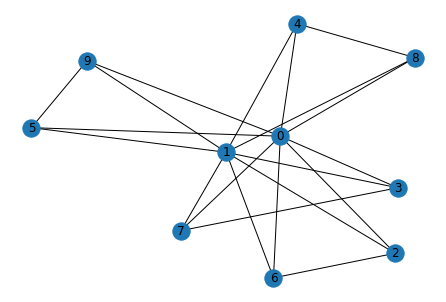

In [50]:
source = [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,3,4,5]
target = [2,3,4,5,6,7,8,9,2,3,4,5,6,7,8,9,6,7,8,9]

g = nx.Graph()
g.add_nodes_from(range(10))
g.add_edges_from(zip(source,target))

# Plot graph
#pos = nx.drawing.nx_agraph.graphviz_layout(g, prog='dot')
nx.draw(g, with_labels=True)
# plt.figure(figsize=(10, 6))
plt.show()

In [51]:
# Run algorithms
celf_output   = celf(g,2,p = 0.2,mc = 1000)
greedy_output = greedy(g,2,p = 0.2,mc = 1000)

# Print results
print("celf output:   " + str(celf_output[0]))
print("greedy output: " + str(greedy_output[0]))

celf output:   [1, 6]
greedy output: [1, 6]


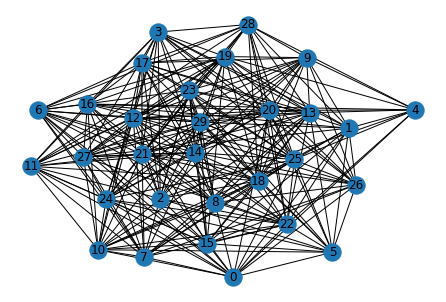

In [52]:
# Generate Graph
G = nx.erdos_renyi_graph(30,0.6)

# Plot graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, arrows=True)
plt.show()


In [53]:
# Run algorithms
celf_output   = celf(G,10,p = 0.1,mc = 1000)
#greedy_output = greedy(G,10,p = 0.1,mc = 1000)

# Print resulting seed sets
print("celf output:   " + str(celf_output[0]))
print("celf output:   " + str(celf_output[1]))
#print("greedy output: " + str(greedy_output[0]))

celf output:   [3, 6, 0, 4, 5, 1, 29, 2, 12, 7]
celf output:   [11.171, 12.63, 13.839, 14.999, 16.096, 17.086, 17.946, 18.763, 19.494, 20.211]


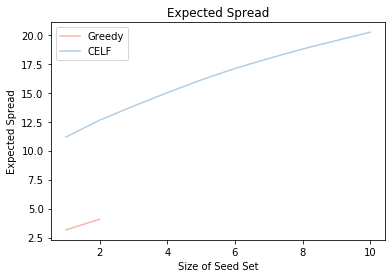

In [54]:
# Plot Expected Spread by Seed Set Size
plt.plot(range(1,len(greedy_output[1])+1),greedy_output[1],label="Greedy",color="#FBB4AE")
plt.plot(range(1,len(celf_output[1])+1),celf_output[1],label="CELF",color="#B3CDE3")
plt.xlabel('Size of Seed Set'); plt.ylabel('Expected Spread')
plt.title('Expected Spread'); plt.legend(loc=2);

In [55]:
G.adj[0]

AtlasView({1: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 10: {}, 11: {}, 15: {}, 20: {}, 21: {}, 22: {}, 24: {}, 25: {}, 26: {}, 27: {}})

[0, 29, 5]


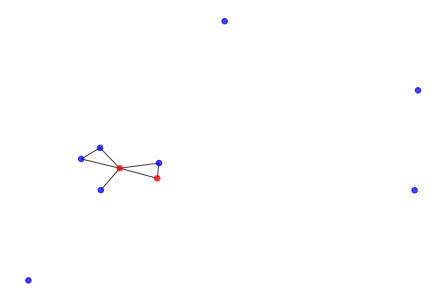

In [58]:
source = [0,0,0,0,0,1,5]
target = [1,2,3,4,5,2,4]

g = nx.Graph()
g.add_nodes_from(range(10))
g.add_edges_from(zip(source,target))

celf_output   = celf(G,3,p = 0.1,mc = 50)

print(celf_output[0])

def color(x):
    if x in celf_output[0]:
        return('red')
    else:
        return('blue')
    
nx.draw(g,node_color=[color(x) for x in g.nodes()],alpha=.75, node_size=30)

In [59]:
source = [0,0,0,1,0,0,0,0,1,1,1,1,1,2,1]
target = [2,3,4,5,6,7,8,9,2,3,4,5,6,7,8]

g = nx.Graph()
g.add_nodes_from(range(10))
print(g.nodes())
g.add_edges_from(zip(source,target))


# Run algorithms
# celf_output   = celf(g,2,p = 0.2,mc = 1000)
# greedy_output = greedy(g,2,p = 0.2,mc = 1000)

# # Print results
# print("celf output:   " + str(celf_output[0]))
# print("greedy output: " + str(greedy_output[0]))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [60]:
np.random.seed(0)
success = np.random.uniform(0,1,len(g.adj[5])) < 0.5
#                 for i in range(len(g.adj[node])):
#                     if success[i]==1:
#                         new_ones.append(list(g.adj[node])[i])
print(list(np.extract(success, g.adj[5])))

KeyError: 0

In [43]:
print(np.array(list(g.adj[9].keys())))

[0]


In [44]:
print(success)

[False]


In [46]:
np.extract(success, np.array(list(g.adj[9].keys())))

array([], dtype=int32)